In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from Elrond.Helpers.array_utility import pandas_collumn_to_2d_numpy_array
from scipy.signal import spectrogram, welch
from sklearn.cluster import KMeans
from scipy.ndimage import gaussian_filter1d
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from pathlib import Path
import pynapple as nap
from scipy.ndimage import gaussian_filter, rotate
from scipy.signal import find_peaks, peak_prominences, spectrogram
from scipy.stats import zscore

from spatial_manifolds.data.binning import get_bin_config
from spatial_manifolds.data.loading import load_session
from spatial_manifolds.util import gaussian_filter_nan
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2


/opt/anaconda3/envs/sm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def plot_stop_raster(derivatives, tl):
    trial_numbers = np.array(derivatives["behaviour"]['trial_number'])
    position = np.array(derivatives["behaviour"]['P'])
    trial_types = np.array(derivatives["behaviour"]['trial_type'])
    speed = np.array(derivatives["behaviour"]['S'])
    stopped = np.array(derivatives["behaviour"]['below_speed_threshold'])
    b_mask = trial_types==0
    nb_mask = trial_types==1
    stop_mask = stopped==1
    plt.scatter(position[(b_mask & stop_mask)], trial_numbers[(b_mask & stop_mask)], color='black')
    plt.scatter(position[(nb_mask & stop_mask)], trial_numbers[(nb_mask & stop_mask)], color='red')
    plt.xlim(0,tl)

def circ_mean(x, axis=-1, keepdims=False):
    """Calculate circular mean."""
    return np.arctan2(
        np.sin(x).mean(axis, keepdims=keepdims), np.cos(x).mean(axis, keepdims=keepdims)
    )


def plot_firing_rate_map(ax, tc, bs, tl):
    p = np.nanpercentile(tc, 99)
    tc = np.clip(tc, max=p)
    bpt = tl/bs
    n_trials = int(len(tc)/(bpt))
    trial_rate_map = []
    for i in range(n_trials):
        trial_rate_map.append(tc[int(i*bpt): int((i+1)*bpt)])
    trial_rate_map = np.array(trial_rate_map)    
    ax.imshow(trial_rate_map, cmap='binary')
    ax.invert_yaxis()


def plot_avg_firing_rate_map(ax, tc, bs, tl, mask=None, c='black'):
    p = np.nanpercentile(tc, 99)
    tc = np.clip(tc, max=p)
    bpt = tl/bs
    n_trials = int(len(tc)/(bpt))

    trial_rate_map = []
    for i in range(n_trials):
        trial_rate_map.append(tc[int(i*bpt): int((i+1)*bpt)])
    trial_rate_map = np.array(trial_rate_map)  

    if mask is not None:
        trial_rate_map=trial_rate_map[mask]
        
    ax.plot(np.arange(bpt), np.nanmean(trial_rate_map,axis=0), color=c)
    ax.fill_between(np.arange(bpt), np.nanmean(trial_rate_map,axis=0)-stats.sem(trial_rate_map, axis=0,nan_policy="omit"),
                                    np.nanmean(trial_rate_map,axis=0)+stats.sem(trial_rate_map, axis=0,nan_policy="omit"),alpha=0.3, color=c)

In [3]:
mouse = 25
day = 21
session_type = 'VR'
sorter = 'kilosort4'
storage = Path('/Users/harryclark/Downloads/nwb_data/')
alpha = 0.001
n_jobs = 8
n_shuffles = 100
seed = 1

class Args:
    def __init__(self,mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed):
        self.mouse = mouse
        self.day = day
        self.session_type = session_type
        self.sorter = sorter
        self.storage = storage
        self.alpha = alpha
        self.n_jobs = n_jobs
        self.n_shuffles = n_shuffles
        self.seed = seed
args = Args(mouse,day,session_type,sorter,storage,alpha,n_jobs,n_shuffles,seed)

if session_type == 'VR':
    tl = 200
elif session_type == 'MCVR':
    tl = 230


first position: 108.88949394226074
this mouse started on trial number 16
this mouse ended on trial number 202
this completed experienced 187.0 trials
each trial equates to 230 cm
this mouse travelled 428.73302392959596 meters
we will use a bin size of 1 cm and 43010 bins


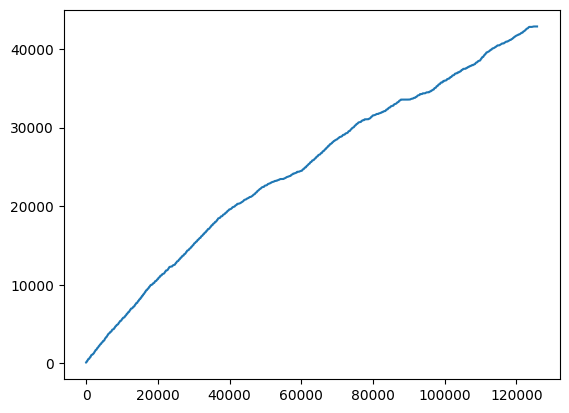

In [4]:
# Load session
session, session_path, neurons = load_session(args)
tuning_scores = {
    path.with_suffix('').name: pd.read_parquet(path)
    for path in (session_path / 'tuning_scores').iterdir()
}
ramp_scores = tuning_scores['ramp_class']
bin_config = get_bin_config(session_type)['P']

bin_size_cm = 1
positions = np.array(session['P'])
times = np.array(session['P'].index)
trial_numbers = np.array(session['trial_number'])
trial_types =  np.array(session['trial_type'])
distance_travelled = positions+(tl*(trial_numbers-1))
distance_travelled_adjusted = distance_travelled-((trial_numbers[0]-1)*tl)
n_bins = int(int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)/bin_size_cm)
max_bound = int(((np.ceil(np.nanmax(distance_travelled_adjusted))//tl)+1)*tl)
min_bound = 0

tmp_TSD = nap.TsdFrame(t=times, d=distance_travelled_adjusted, columns=['dt'])

print(f'first position: {positions[0]}')
print(f'this mouse started on trial number {int(np.min(trial_numbers))}')
print(f'this mouse ended on trial number {int(np.max(trial_numbers))}')
print(f'this completed experienced {np.max(trial_numbers)-np.min(trial_numbers)+1} trials')
print(f'each trial equates to {tl} cm')
print(f'this mouse travelled {np.nanmax(distance_travelled_adjusted)/100} meters')
print(f'we will use a bin size of {bin_size_cm} cm and {n_bins} bins')
plt.plot(distance_travelled_adjusted)
plt.show()

# make tc masks fr contexts and trial types
context1b_mask =  np.isin(np.unique(trial_numbers), trial_numbers[trial_types==0])
context1nb_mask = np.isin(np.unique(trial_numbers), trial_numbers[trial_types==1])
context2b_mask =  np.isin(np.unique(trial_numbers), trial_numbers[trial_types==2])
context2nb_mask = np.isin(np.unique(trial_numbers), trial_numbers[trial_types==3])

In [5]:
tcs = []
for index in neurons.index:
    this_neuron = neurons[neurons.index == index]
    tc = nap.compute_1d_tuning_curves(this_neuron, tmp_TSD["dt"], nb_bins=n_bins, minmax=[min_bound, max_bound])[index]
    mask = np.isnan(tc)
    tc = gaussian_filter(np.nan_to_num(tc).astype(np.float64), sigma=bin_config['smooth_sigma'])
    tcs.append(tc)

In [6]:
'''
ncols = 6
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            plot_firing_rate_map(ax[j, i], 
                                zscore(tcs[counter]), 
                                tl=tl)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()


ncols = 6
nrows = int(np.ceil(len(tcs)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(tcs)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(tcs):
            plot_avg_firing_rate_map(ax[j, i], zscore(tcs[counter]), tl=tl, mask=context1b_mask,  c='black')
            plot_avg_firing_rate_map(ax[j, i], zscore(tcs[counter]), tl=tl, mask=context1nb_mask, c='red')
            plot_avg_firing_rate_map(ax[j, i], zscore(tcs[counter]), tl=tl, mask=context2b_mask,  c='green')
            plot_avg_firing_rate_map(ax[j, i], zscore(tcs[counter]), tl=tl, mask=context2nb_mask, c='blue')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.tight_layout()
plt.show()
'''

"\nncols = 6\nnrows = int(np.ceil(len(tcs)/ncols))\nfig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(tcs)/6)/4)), squeeze=False)\ncounter = 0\nfor j in range(nrows):\n    for i in range(ncols):\n        if counter<len(tcs):\n            plot_firing_rate_map(ax[j, i], \n                                zscore(tcs[counter]), \n                                tl=tl)\n        ax[j, i].set_xticks([])\n        ax[j, i].set_yticks([])\n        ax[j, i].xaxis.set_tick_params(labelbottom=False)\n        ax[j, i].yaxis.set_tick_params(labelleft=False)\n        counter+=1\nplt.tight_layout()\nplt.show()\n\n\nncols = 6\nnrows = int(np.ceil(len(tcs)/ncols))\nfig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(tcs)/6)/4)), squeeze=False)\ncounter = 0\nfor j in range(nrows):\n    for i in range(ncols):\n        if counter<len(tcs):\n            plot_avg_firing_rate_map(ax[j, i], zscore(tcs[counter]), tl=tl, mask=context1b_mask,  c='black')\n          

In [7]:
def spectral_analysis(tcs, tl, bs, windowsize=2):
    """
    tcs: list of 1d np.array
    tl: track length
    bs: size of bin in cm
    windowsize: how many track lengths to compute over
    """
    k=6 
    dark_only = False
    """Perform spectral analysis of grid cells."""
    N = len(tcs)
    L = tl/bs
    zmaps = tcs
    trial_starts = (0,len(tcs[0])) # unused in our data as we dont have a dark only epoch
    min_freq, max_freq = 1 / 500, 1 / 20  # cm^-1
    nperseg = windowsize * L
    nperseg = 1600

    Sxs, phase_grams = [], []
    for mp in zmaps:
        f, t, Sxx = spectrogram(mp.ravel(), nperseg=nperseg, noverlap=1400)
        _, _, phase_gram = spectrogram(
            mp.ravel(), nperseg=nperseg, mode="angle", noverlap=1400
        )
        Sxs.append(Sxx[(min_freq < f) & (f < max_freq)])
        phase_grams.append(phase_gram[(min_freq < f) & (f < max_freq)])

    #for pg in phase_grams:
    #    plt.imshow(pg)
    #    plt.show()

    phase_grams = np.stack(phase_grams).T
    Sxs = np.stack(Sxs)
    Sxs = np.nan_to_num(Sxs / (np.linalg.norm(Sxs, axis=1, keepdims=True) + 1e-5))

    print(len(Sxs))
    print(N)

    fvalid = f[(min_freq < f) & (f < max_freq)]
    cutoff_idx = np.where(min_freq < f)[0][0]
    start_trial, end_trial = trial_starts[0], trial_starts[1]

    dark_idxs = (
        np.concatenate([np.where((t / L > start_trial) & (t / L < end_trial))[0]])
        if dark_only
        else np.arange(len(t))
    )
    RR = np.corrcoef(Sxs[:, :, dark_idxs].reshape(N, -1))
    np.fill_diagonal(RR, 0)

    # Cluster by spectrograms
    kmeans = KMeans(n_clusters=k, n_init="auto", random_state=0)
    kmeans.fit(Sxs[:, :, dark_idxs].reshape(N, -1))

    avg_corrs = []
    for mi in range(k):
        grid_cell_idxs = np.where(kmeans.labels_ == mi)[0]
        avg_corrs.append(RR[grid_cell_idxs][:, grid_cell_idxs].mean())
    avg_corrs = np.stack(avg_corrs)
    module_idxs = np.where(avg_corrs > 0.3)[0]
    print("Identified {} candidate modules".format(len(module_idxs)))

    f_modules, phi_modules, grid_cell_idxs_modules = [], [], []
    for mi in module_idxs:
        grid_cell_idxs = np.where(kmeans.labels_ == mi)[0]
        grid_cell_idxs_modules.append(grid_cell_idxs)

        S = Sxs[grid_cell_idxs].mean(0).reshape(-1, len(t)).T
        peak1s = []
        peak2s = []
        peak3s = []
        f1s = []
        f2s = []
        f3s = []
        phi1s, phi2s, phi3s = [], [], []
        colinearity_scores = []
        for phase_gram, s in zip(phase_grams, S):
            peaks, _ = find_peaks(s, distance=1)
            proms, _, _ = peak_prominences(s, peaks)
            top_peaks = peaks[np.argsort(proms)][-2:]
            if len(top_peaks) > 0:
                peak1, peak2 = np.min(top_peaks), np.max(top_peaks)
                if peak1 + peak2 + cutoff_idx >= len(fvalid):
                    peak3 = np.abs(peak1 - peak2) - cutoff_idx
                elif np.abs(peak1 - peak2) - cutoff_idx < 0:
                    peak3 = peak1 + peak2 + cutoff_idx
                else:
                    peak3_options = [
                        peak1 + peak2 + cutoff_idx,
                        np.abs(peak1 - peak2) - cutoff_idx,
                    ]
                    peak3 = peak3_options[np.argmax(s[peak3_options])]
                peak1s.append(peak1)
                peak2s.append(peak2)
                peak3s.append(peak3)
                f1s.append(fvalid[peak1])
                f2s.append(fvalid[peak2])
                f3s.append(fvalid[peak3])
                phi1s.append(phase_gram[peak1])
                phi2s.append(phase_gram[peak2])
                phi3s.append(phase_gram[peak3])
                uniq_peaks = np.unique([peak1, peak2, peak3])
                colinearity_scores.append(
                    100 * (s[uniq_peaks] ** 2).sum() / (s**2).sum()
                )
            else:
                peak1s.append(np.nan)
                peak2s.append(np.nan)
                peak3s.append(np.nan)
                f1s.append(np.nan)
                f2s.append(np.nan)
                f3s.append(np.nan)
                phi1s.append(np.nan)
                phi2s.append(np.nan)
                phi3s.append(np.nan)
                colinearity_scores.append(np.nan)
        f1s = np.stack(f1s)
        f2s = np.stack(f2s)
        f3s = np.stack(f3s)
        phi1s = np.stack(phi1s)
        phi2s = np.stack(phi2s)
        phi3s = np.stack(phi3s)

        phi1_dark = phi1s[dark_idxs][:, grid_cell_idxs]
        phi1_dark = (phi1_dark - circ_mean(phi1_dark, axis=-1, keepdims=True)) % (
            2 * np.pi
        )
        phi2_dark = phi2s[dark_idxs][:, grid_cell_idxs]
        phi2_dark = (phi2_dark - circ_mean(phi2_dark, axis=-1, keepdims=True)) % (
            2 * np.pi
        )
        phi3_dark = phi3s[dark_idxs][:, grid_cell_idxs]
        phi3_dark = (phi3_dark - circ_mean(phi3_dark, axis=-1, keepdims=True)) % (
            2 * np.pi
        )

        xy1 = np.hstack([np.cos(phi1_dark), np.sin(phi1_dark)])
        xy2 = np.hstack([np.cos(phi2_dark), np.sin(phi2_dark)])
        xy3 = np.hstack([np.cos(phi3_dark), np.sin(phi3_dark)])
        xy = [xy1, xy2, xy3]

        kmeans_phases = KMeans(n_clusters=3, n_init="auto", random_state=0)
        kmeans_phases.fit(np.vstack(xy))
        labels = np.stack(np.split(kmeans_phases.labels_, 3)).T

        phi_all = [phi1_dark, phi2_dark, phi3_dark]
        fs_all = [f1s, f2s, f3s]

        fs = {}
        phis = {}
        for j in range(3):
            phis[j] = []
            fs[j] = []
        for i in range(len(dark_idxs)):
            for j in range(3):
                label = np.where(labels[i] == j)[0]
                if len(label) > 0:
                    phis[j].append(phi_all[label[0]][i])
                    fs[j].append(fs_all[label[0]][i])
                else:
                    min_label = (
                        ((np.stack(xy)[:, i] - kmeans_phases.cluster_centers_[j]) ** 2)
                        .sum(-1)
                        .argmin()
                    )
                    fs[j].append(fs_all[min_label][i])
                    phis[j].append(phi_all[min_label][i])

        for j in range(3):
            phis[j] = np.stack(phis[j])
            fs[j] = np.stack(fs[j])
        f_modules.append(fs)

        phases_all = []
        for j in range(3):
            r = np.corrcoef(np.sin(phis[j]))
            np.fill_diagonal(r, 0)
            phases_all.append(circ_mean(phis[j][r.max(0) > 0.5], axis=0))
        phi_modules.append(phases_all)

        scales = []
        for fs in f_modules:
            scale = np.sqrt(2 / (np.stack([f for f in fs.values()])**2).sum(0)).mean()
            scales.append(scale)
        
        scale_sort = np.argsort(scales)
        f_modules = [f_modules[i] for i in scale_sort]
        phi_modules = [phi_modules[i] for i in scale_sort]
        grid_cell_idxs_modules = [grid_cell_idxs_modules[i] for i in scale_sort]

    return [f_modules, 
            phi_modules, 
            grid_cell_idxs_modules, 
            Sxs,
            t,
            L,
            trial_starts]


In [8]:
N = len(tcs)
zmaps = np.array(tcs)
trial_starts = (0,len(tcs[0]))

results = spectral_analysis(tcs, tl, bs=bin_size_cm)
f_modules = results[0]
phi_modules = results[1]
grid_cell_idxs_modules = results[2]
spectrograms = results[3]
L = tl
trial_starts = results[6]

229
229
Identified 3 candidate modules


Text(0.5, 1.0, 'PSDs')

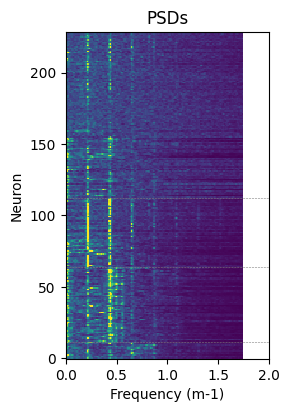

In [9]:
# Plot PSDs
plt.figure(figsize=(3,4))
nongrid_idxs = np.setdiff1d(np.arange(N), np.concatenate(grid_cell_idxs_modules))
fmax = 8/L
count = 0
Ps = []
for j in range(len(grid_cell_idxs_modules)):
    grid_cell_idxs = grid_cell_idxs_modules[j]
    for gi in grid_cell_idxs:
        mp = gaussian_filter1d(zmaps[gi].ravel(), 3)
        f, Pxx = welch(mp,nperseg=4000,noverlap=3000)
        # Ps.append(Pxx[f<fmax])
        Ps.append(Pxx[f<fmax]/(Pxx[f<fmax]).sum())
    count += len(grid_cell_idxs)
    plt.axhline(count, c='grey',linestyle='dashed',linewidth=0.4)
for ngi in nongrid_idxs:
    mp = gaussian_filter1d(zmaps[ngi].ravel(), 3)
    f, Pxx = welch(mp,nperseg=4000,noverlap=3000)
    Ps.append(Pxx[f<fmax]/(Pxx[f<fmax]).sum())
Ps = np.stack(Ps)

plt.pcolormesh(100*f[f<fmax]/2,np.arange(len(Ps)),np.stack(Ps),vmax=0.04)
plt.xlabel(f'Frequency (m-1)')
plt.xlim([0,2])
plt.ylabel('Neuron')
plt.tight_layout()
plt.title('PSDs')

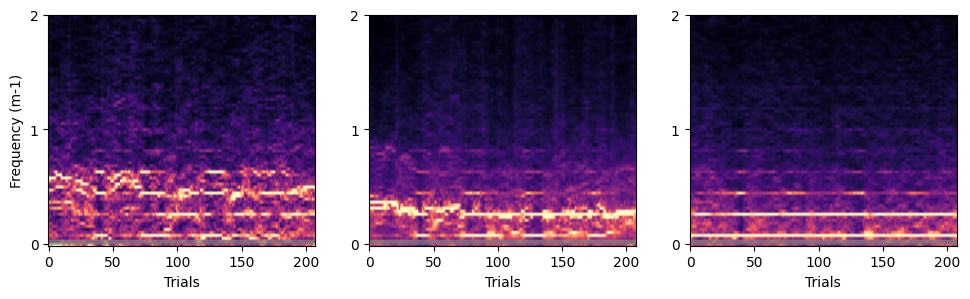

In [10]:
# Module spectrograms
plt.figure(figsize=(20,3))
mi = 2
for i, grid_cell_idxs in enumerate(grid_cell_idxs_modules):
    plt.subplot(1,5,i+1)
    Ng = len(grid_cell_idxs)
    S = spectrograms[grid_cell_idxs].mean(0)
    plt.imshow(S,origin='lower',aspect='auto',vmax=0.25,cmap='magma')
    plt.yticks([0, len(S)/2, len(S)], [0, 1, 2])
    
    if i==0:
        plt.ylabel(f'Frequency (m-1)')

    for i in range(1,8):
        plt.axhline(100*i/L/2,linewidth=1,c='grey',alpha=0.5)
        
    for ts in trial_starts[1:-1]:
        plt.axvline(ts,linewidth=1,c='grey',alpha=0.5)
    plt.xlabel('Trials')

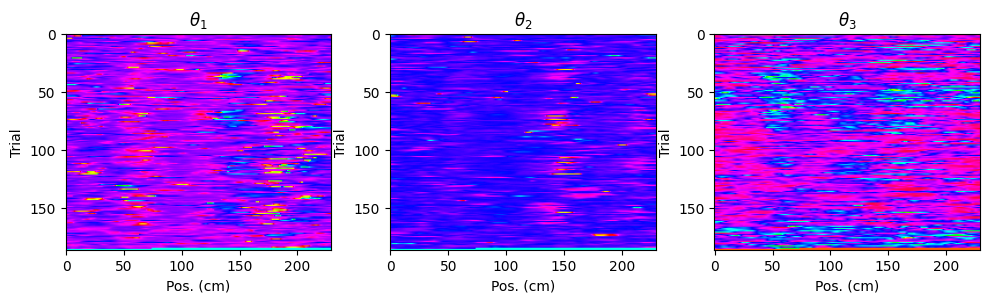

In [11]:
# Plot trajectories on the neural sheet
grid_cell_idxs = grid_cell_idxs_modules[0]
phi = phi_modules[0]
Ng = len(grid_cell_idxs)

maps = gaussian_filter1d(zmaps[grid_cell_idxs].reshape(Ng, -1), 2, axis=1)
# maps = zmaps[grid_cell_idxs].reshape(Ng,-1)
angles = np.arctan2(np.cos(phi)@maps, np.sin(phi)@maps)


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5), squeeze=False)

ax[0,0].set_title(r'$\theta_1$')
ax[0,0].imshow(angles[0].reshape(-1,L),cmap='hsv')
for ts in trial_starts[1:-1]:
    ax[0,0].axhline(ts,color='k',linestyle='dashed',linewidth=1)
ax[0,0].set_xlabel('Pos. (cm)')
ax[0,0].set_ylabel('Trial')

ax[0,1].imshow(angles[1].reshape(-1,L),cmap='hsv')
ax[0,1].set_title(r'$\theta_2$')
for ts in trial_starts[1:-1]:
    ax[0,1].axhline(ts,color='k',linestyle='dashed',linewidth=1)
ax[0,1].set_ylabel('Trial')
ax[0,1].set_xlabel('Pos. (cm)')

ax[0,2].imshow(angles[2].reshape(-1,L),cmap='hsv')
ax[0,2].set_title(r'$\theta_3$')
for ts in trial_starts[1:-1]:
    ax[0,2].axhline(ts,color='k',linestyle='dashed',linewidth=1)
ax[0,2].set_ylabel('Trial')
ax[0,2].set_xlabel('Pos. (cm)')

plt.tight_layout(w_pad=0.2)

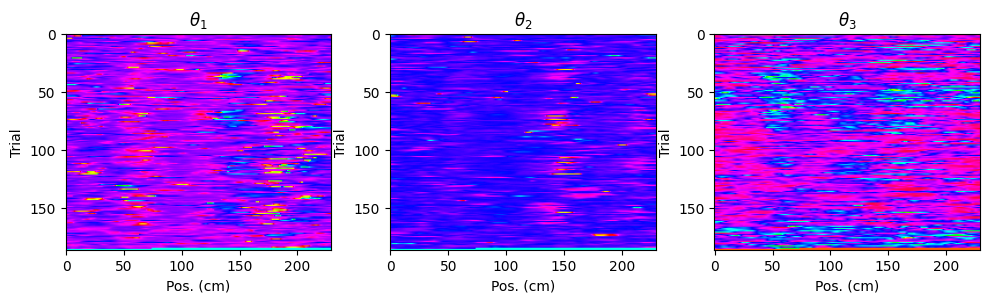

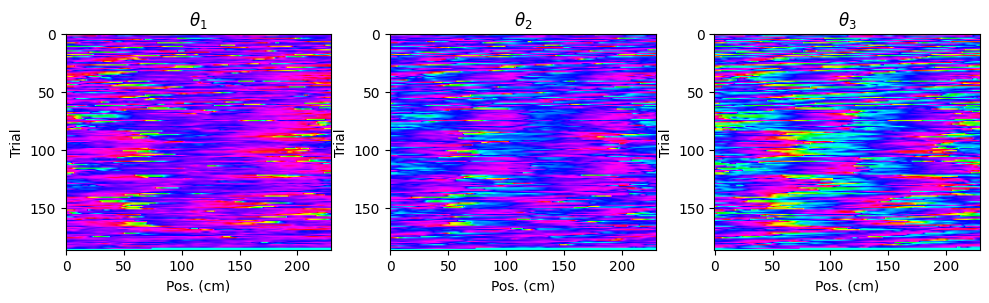

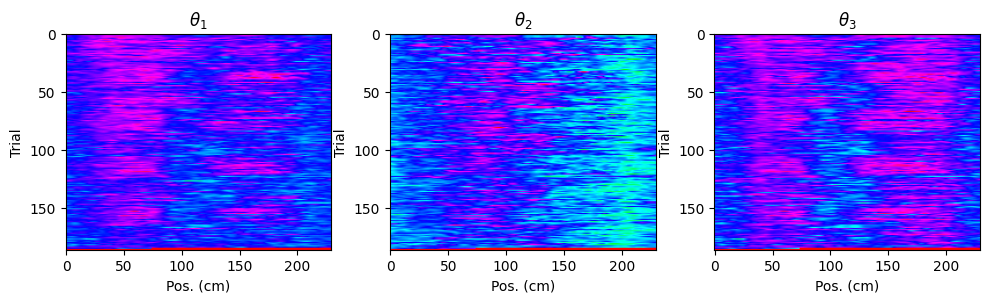

In [12]:
for i in range(len(grid_cell_idxs_modules)):

    # Plot trajectories on the neural sheet
    grid_cell_idxs = grid_cell_idxs_modules[i]
    phi = phi_modules[i]
    Ng = len(grid_cell_idxs)

    maps = gaussian_filter1d(zmaps[grid_cell_idxs].reshape(Ng, -1), 2, axis=1)
    # maps = zmaps[grid_cell_idxs].reshape(Ng,-1)
    angles = np.arctan2(np.cos(phi)@maps, np.sin(phi)@maps)


    fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10, 5), squeeze=False)

    ax[0,0].set_title(r'$\theta_1$')
    ax[0,0].imshow(angles[0].reshape(-1,L),cmap='hsv')
    for ts in trial_starts[1:-1]:
        ax[0,0].axhline(ts,color='k',linestyle='dashed',linewidth=1)
    ax[0,0].set_xlabel('Pos. (cm)')
    ax[0,0].set_ylabel('Trial')

    ax[0,1].imshow(angles[1].reshape(-1,L),cmap='hsv')
    ax[0,1].set_title(r'$\theta_2$')
    for ts in trial_starts[1:-1]:
        ax[0,1].axhline(ts,color='k',linestyle='dashed',linewidth=1)
    ax[0,1].set_ylabel('Trial')
    ax[0,1].set_xlabel('Pos. (cm)')

    ax[0,2].imshow(angles[2].reshape(-1,L),cmap='hsv')
    ax[0,2].set_title(r'$\theta_3$')
    for ts in trial_starts[1:-1]:
        ax[0,2].axhline(ts,color='k',linestyle='dashed',linewidth=1)
    ax[0,2].set_ylabel('Trial')
    ax[0,2].set_xlabel('Pos. (cm)')

    plt.tight_layout(w_pad=0.2)

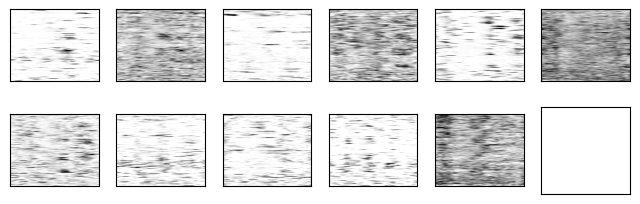

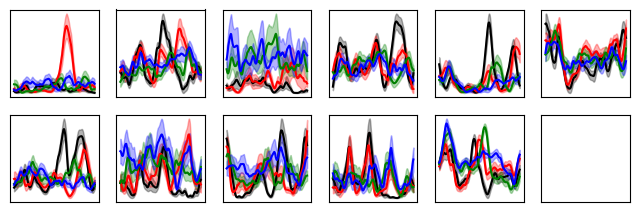

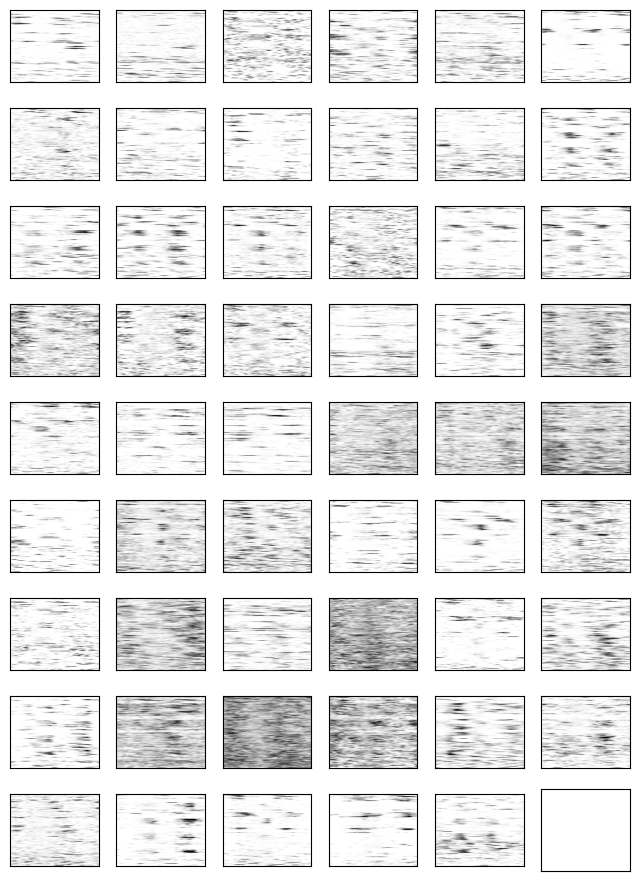

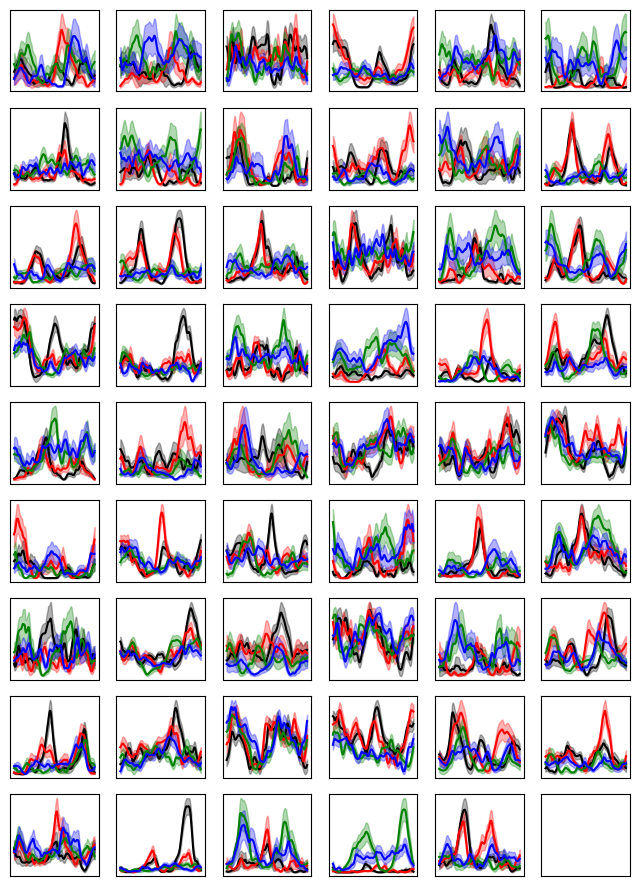

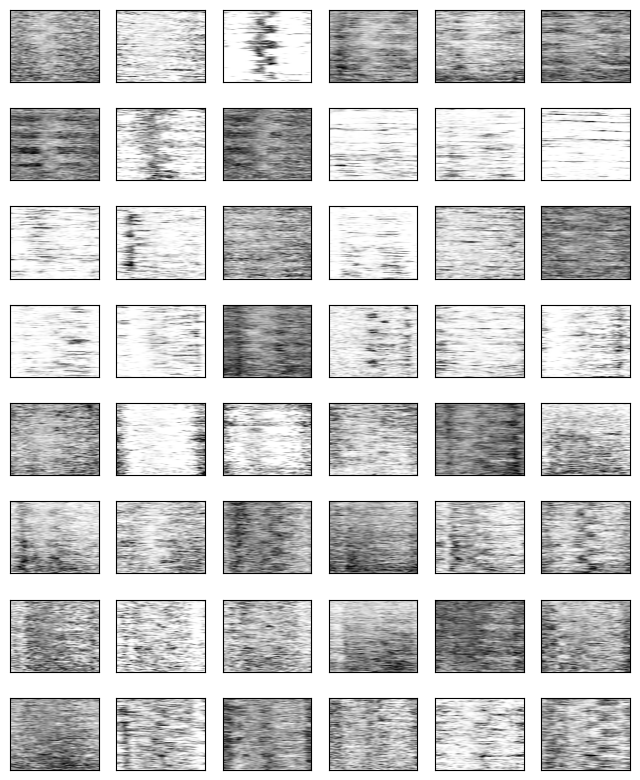

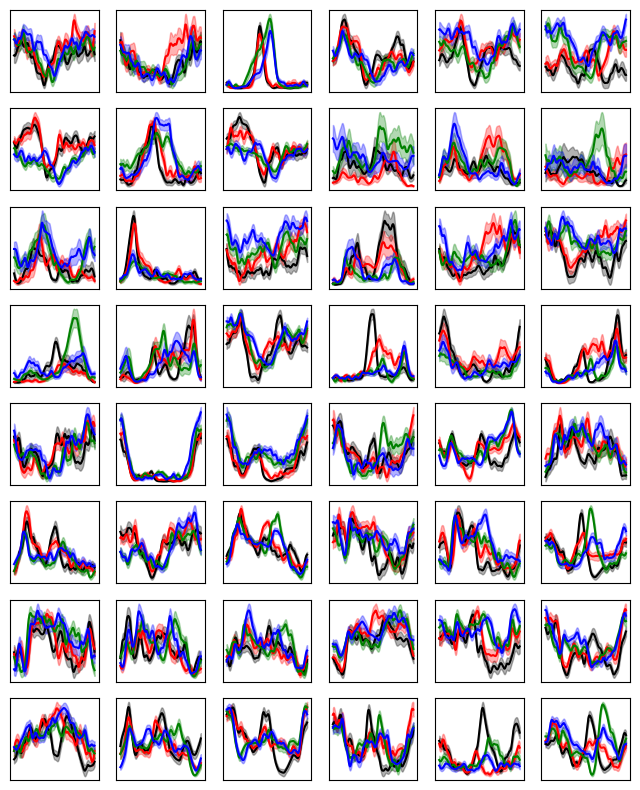

In [13]:
all_grid_cell_idxs =np.array([])
for i in range(len(grid_cell_idxs_modules)):
    grid_cell_idxs = grid_cell_idxs_modules[i]
    
    maps = []
    for gi in grid_cell_idxs:
        mp = gaussian_filter1d(zmaps[gi].ravel(), 3)
        maps.append(mp)
  
    ncols = 6
    nrows = int(np.ceil(len(maps)/ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(maps)/6)/4)), squeeze=False)
    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(maps):
                plot_firing_rate_map(ax[j, i], 
                                     zscore(maps[counter]),
                                     bs=bin_size_cm, 
                                     tl=tl)
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            counter+=1
    plt.show()


    ncols = 6
    nrows = int(np.ceil(len(maps)/ncols))
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(maps)/6)/4)), squeeze=False)
    counter = 0
    for j in range(nrows):
        for i in range(ncols):
            if counter<len(maps):
                plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context1b_mask,  c='black')
                plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context1nb_mask, c='red')
                plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context2b_mask,  c='green')
                plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context2nb_mask, c='blue')
            ax[j, i].set_xticks([])
            ax[j, i].set_yticks([])
            ax[j, i].xaxis.set_tick_params(labelbottom=False)
            ax[j, i].yaxis.set_tick_params(labelleft=False)
            counter+=1
    plt.show()

    
    all_grid_cell_idxs = np.append(all_grid_cell_idxs, grid_cell_idxs)
all_grid_cell_idxs = np.array(all_grid_cell_idxs)
non_grid_cell_idxs = np.setdiff1d(np.arange(0,N), all_grid_cell_idxs)

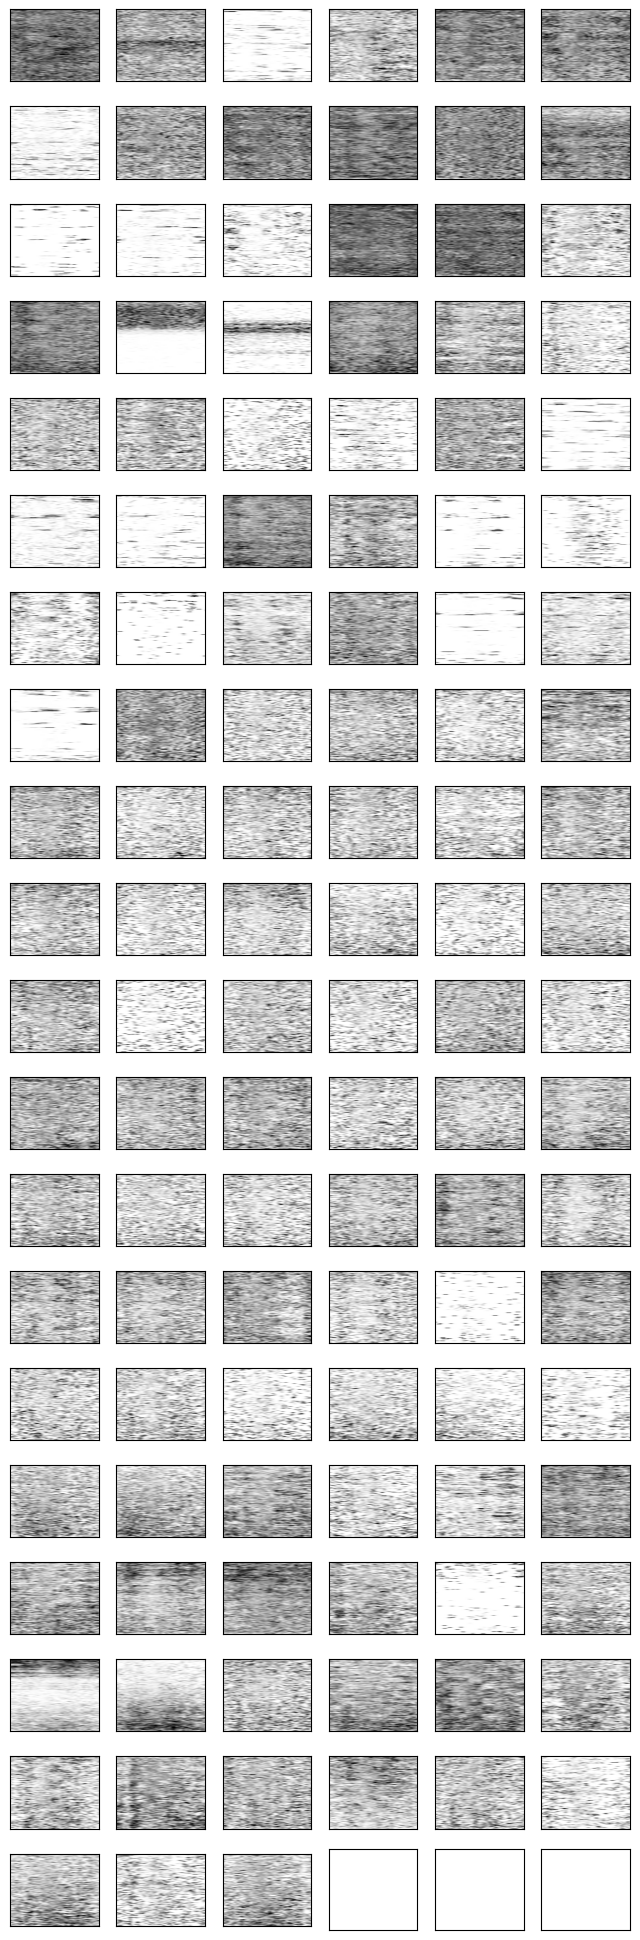

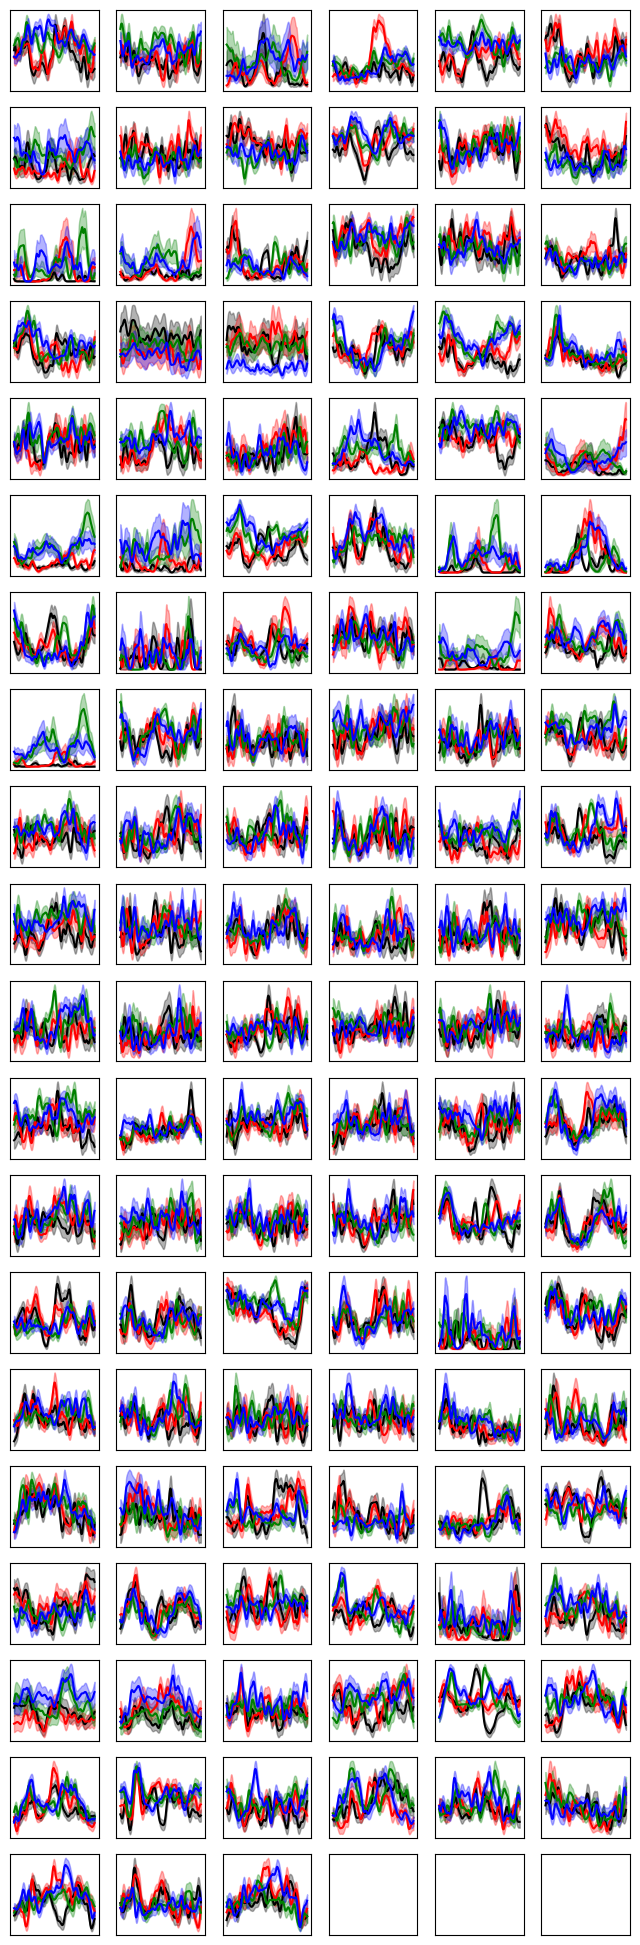

In [14]:
maps = []
for ngi in non_grid_cell_idxs:
    mp = gaussian_filter1d(zmaps[ngi].ravel(), 3)
    maps.append(mp)

ncols = 6
nrows = int(np.ceil(len(maps)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(maps)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(maps):
            plot_firing_rate_map(ax[j, i], 
                                 zscore(maps[counter]), 
                                 bs=bin_size_cm,
                                 tl=tl)
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.show()


ncols = 6
nrows = int(np.ceil(len(maps)/ncols))
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(8, 5*(np.ceil(len(maps)/6)/4)), squeeze=False)
counter = 0
for j in range(nrows):
    for i in range(ncols):
        if counter<len(maps):
            plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context1b_mask,  c='black')
            plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context1nb_mask, c='red')
            plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context2b_mask,  c='green')
            plot_avg_firing_rate_map(ax[j, i], zscore(maps[counter]), bs=bin_size_cm, tl=tl, mask=context2nb_mask, c='blue')
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
        ax[j, i].xaxis.set_tick_params(labelbottom=False)
        ax[j, i].yaxis.set_tick_params(labelleft=False)
        counter+=1
plt.show()
